<a href="https://colab.research.google.com/github/darkwings/ai-notebooks/blob/main/Routing_essential.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Navigation rudimental

A simple notebook to investigate routing functions of LangGraph, no LLM in this notebook.

In [4]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core tavily-python wikipedia

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

OPENAI_API_KEY: ··········


## Navigate with a function

Let's define a function that switch between a node and another in the workflow.

In [7]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from typing import Literal
import random

class TypedDictState(TypedDict):
    name: str
    mood: Literal["happy","sad"]

# Node Functions
def node_1(state):
    print("---Node 1---")
    return {"name": state['name'] + " is ... "}

def node_2(state):
    print("---Node 2---")
    return {"mood": "happy"}

def node_3(state):
    print("---Node 3---")
    return {"mood": "sad"}

# This is the route function, in this case is simply a random node
#
def decide_mood(state) -> Literal["node_2", "node_3"]:

    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:

        # 50% of the time, we return Node 2
        return "node_2"

    # 50% of the time, we return Node 3
    return "node_3"

Now complete the graph

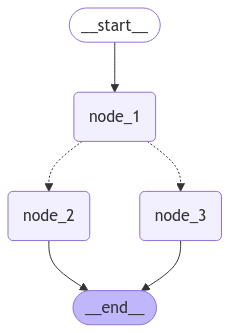

In [8]:
# Build graph
builder = StateGraph(TypedDictState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood) # Conditional edges, explicitely declared
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's invoke

In [12]:
graph.invoke({"name":"Frank"})

---Node 1---
---Node 2---


{'name': 'Frank is ... ', 'mood': 'happy'}

## Commands

Another way to route the flow is use Command. Let's see this in use with a graph similar to the one above

In [14]:
from langgraph.types import Command

def node_1a(state: TypedDictState) -> Command[Literal["node_2", "node_3"]]:
    print("Called A")
    value = random.choice(["a", "b"])
    # this is a replacement for a conditional edge function
    if value == "a":
        goto = "node_2"
    else:
        goto = "node_3"

    # note how Command allows you to BOTH update the graph state AND route to the next node
    return Command(
        # this is the state update if we need to do this
        # update={"foo": value},
        # this is a replacement for an edge
        goto=goto,
    )

Create a graph now, you'll notice that there is no need to add edges, because the navigation is implicitely defined by the use of Command Objects.

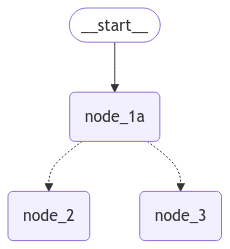

In [17]:
builder = StateGraph(TypedDictState)
builder.add_edge(START, "node_1a")
builder.add_node(node_1a)
builder.add_node(node_2)
builder.add_node(node_3)
# NOTE: there are no edges between nodes 1, 2 and 3!

graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's test again

In [18]:
graph.invoke({"name":"Frank"})

Called A
---Node 2---


{'name': 'Frank', 'mood': 'happy'}

The use of [Command](https://langchain-ai.github.io/langgraph/concepts/low_level/#command) object allows us to create a dynamic flow between the nodes.

## Using command to update the state of the workflow

Let's update the flow, showing how to update the state of a graph with a command.
In order to show how to update the state, we use another state object so we have to define new function


In [22]:
# A dedicated state

class UpdatedState(TypedDict):
  name: str
  decider: str
  mood: Literal["happy", "sad"]

def node_1b(state: UpdatedState) -> Command[Literal["node_2", "node_3"]]:

    coin = random.choice(["head", "tail"])
    # this is a replacement for a conditional edge function
    if coin == "head":
        goto = "node_2"
    else:
        goto = "node_3"

    # note how Command allows you to BOTH update the graph state AND route to the next node
    return Command(
        # this is the state update
        update={"decider": coin},
        # this is a replacement for an edge
        goto=goto,
    )

Now, let's create the graph

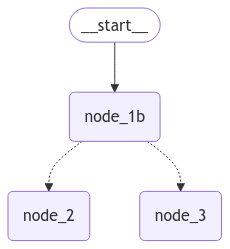

In [23]:
builder = StateGraph(UpdatedState)
builder.add_edge(START, "node_1b")
builder.add_node(node_1b)
builder.add_node(node_2)
builder.add_node(node_3)
# NOTE: there are no edges between nodes 1, 2 and 3!

graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

And now... test it

In [24]:
graph.invoke({"name":"Frank"})

---Node 3---


{'name': 'Frank', 'decider': 'tail', 'mood': 'sad'}